Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Reading the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os # importing os module
import PIL
import glob # Import the glob module
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, Rescaling, RandomFlip, RandomZoom, RandomRotation, RandomBrightness, BatchNormalization
from tensorflow.keras.regularizers import l2

In [2]:
## using the data by mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2246 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNNDataSet/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNNDataSet/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2246
118


### Loading using keras.preprocessing

Loading these images off disk using the helpful image_dataset_from_directory utility.

### Creating a dataset

Defining some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9 # Total 9 categories of images exist.

Using 80% of the images for training, and 20% for validation.

In [6]:
## training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split= 0.2,
                                                               subset= 'training',
                                                               image_size=(img_height,img_width),
                                                               batch_size = batch_size
                                                               )

Found 2246 files belonging to 9 classes.
Using 1797 files for training.


In [7]:
## validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split= 0.2,
                                                             subset= 'validation',
                                                             image_size=(img_height,img_width),
                                                             batch_size = batch_size)

Found 2246 files belonging to 9 classes.
Using 449 files for validation.


In [8]:
# all the classes of skin cancer and stored them in a class_names list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Creating a code to visualize one instance of all the nine classes present in the dataset

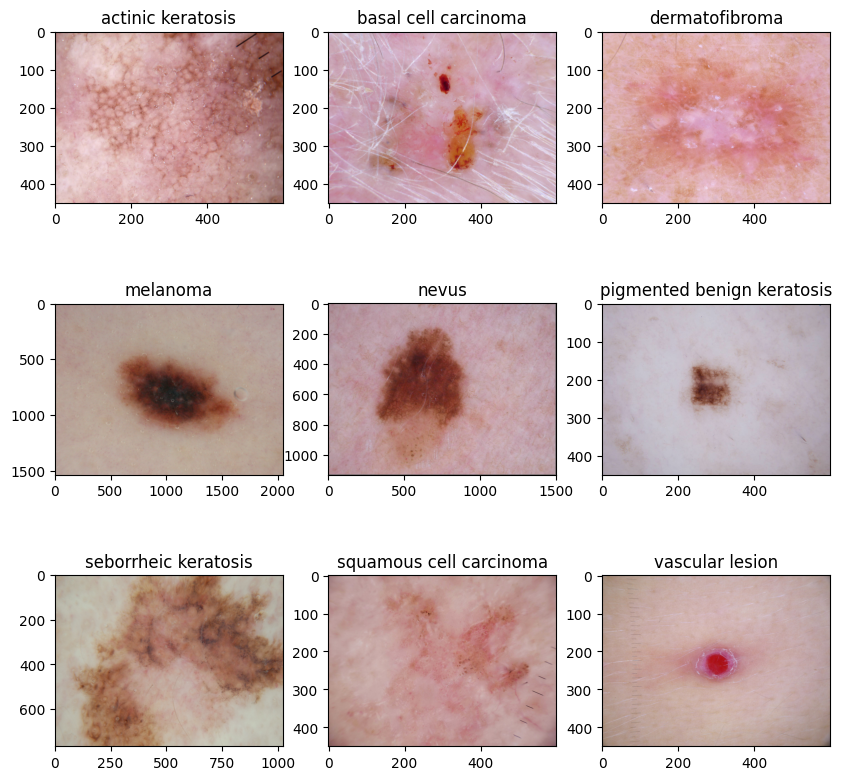

In [9]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32,(3,3), padding='same', activation = 'relu'))
model.add(Conv2D(32,(3,3), padding='same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choosing an appropirate optimiser and loss function for model training

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# Viewing the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     132,710,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,725,673 (506.31 MB)

 Trainable params: 132,725,673 (506.31 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.2039 - loss: 11.3248 - val_accuracy: 0.3140 - val_loss: 1.9350
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.3511 - loss: 1.7971 - val_accuracy: 0.4922 - val_loss: 1.5884
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.4775 - loss: 1.5380 - val_accuracy: 0.4298 - val_loss: 1.6340
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5125 - loss: 1.4515 - val_accuracy: 0.4655 - val_loss: 1.4906
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5967 - loss: 1.1490 - val_accuracy: 0.5212 - val_loss: 1.4069
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6993 - loss: 0.8711 - val_accuracy: 0.5122 - val_loss: 1.5091
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7756 - loss: 0.6790 - val_accuracy: 0.4788 - val_loss: 1.5254
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8134 - loss: 0.5589 - val_accuracy: 0.4833 - val_loss: 1

### Visualizing training results

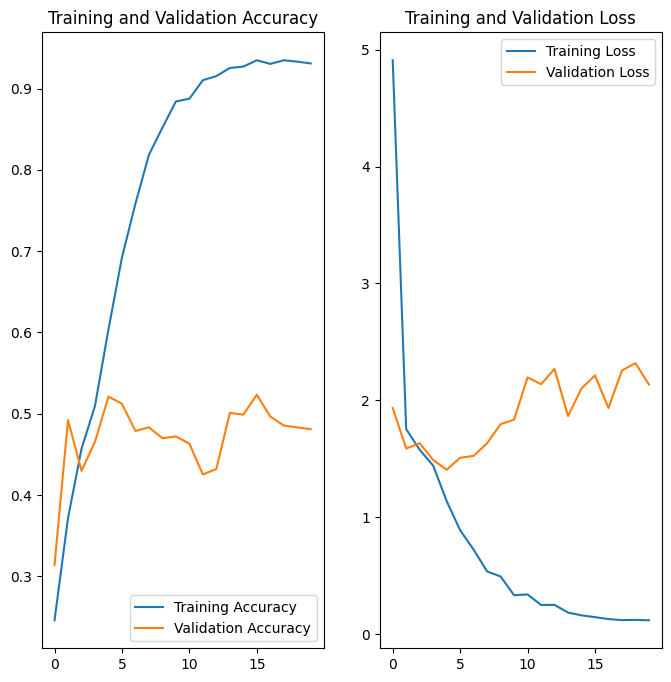

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### This model is **overfitted** as training accuracy (93.79) vs validation accuracy (48.11) gap is huge i.e. triaining accuray is high whereas validation accuracy low.

### Proceeding with data augmentation

In [16]:
# choosing an appropriate data augumentation strategy.

data_augmentation = Sequential([RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),  # Flip images horizontally
                                                RandomRotation(0.2), # Rotate images randomly by 20%
                                                RandomZoom(0.2), # Zoom images randomly
                                                RandomBrightness(0.2)   # Adjust brightness randomly
                                                ])

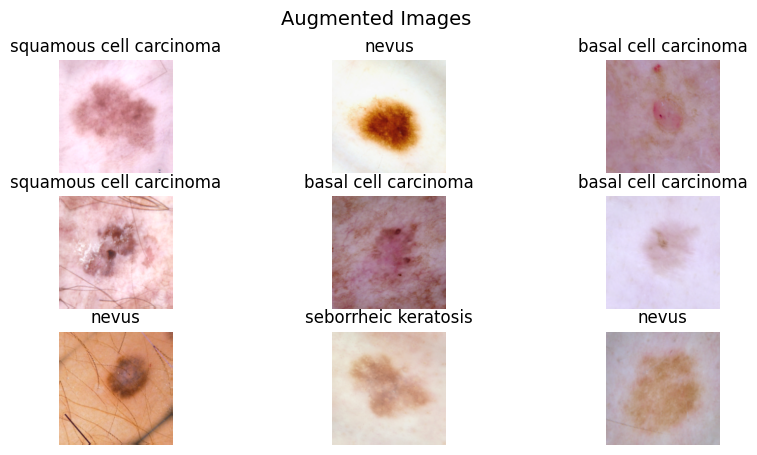

In [17]:
# Visualizing how augmentation strategy working for one instance of training image (in all categories).

# Appling augmentation multiple times and visualizing
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
      plt.subplot(3, 3, i+1)
      plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
plt.suptitle("Augmented Images", fontsize=14)
plt.show()

### Creating the model, compile and train the model


In [18]:
## Using Dropout layer if there is an evidence of overfitting in the above findings
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32,(3,3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01),activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

### Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 334ms/step - accuracy: 0.2379 - loss: 162.9329 - val_accuracy: 0.1514 - val_loss: 102.0865
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 318ms/step - accuracy: 0.2356 - loss: 40.2936 - val_accuracy: 0.1915 - val_loss: 79.9089
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - accuracy: 0.2716 - loss: 24.0922 - val_accuracy: 0.2294 - val_loss: 65.4478
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - accuracy: 0.2727 - loss: 14.1957 - val_accuracy: 0.2517 - val_loss: 54.4449
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 317ms/step - accuracy: 0.3001 - loss: 8.7446 - val_accuracy: 0.2383 - val_loss: 38.4134
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 317ms/step - accuracy: 0.3262 - loss: 5.6782 - val_accuracy: 0.2561 - val_loss: 19.6521
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 317ms/step - accuracy: 0.3615 - loss: 4.0443 - val_accuracy: 0.2784 - val_loss: 7.4058
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.3212 - loss: 3.148

### Visualizing the results

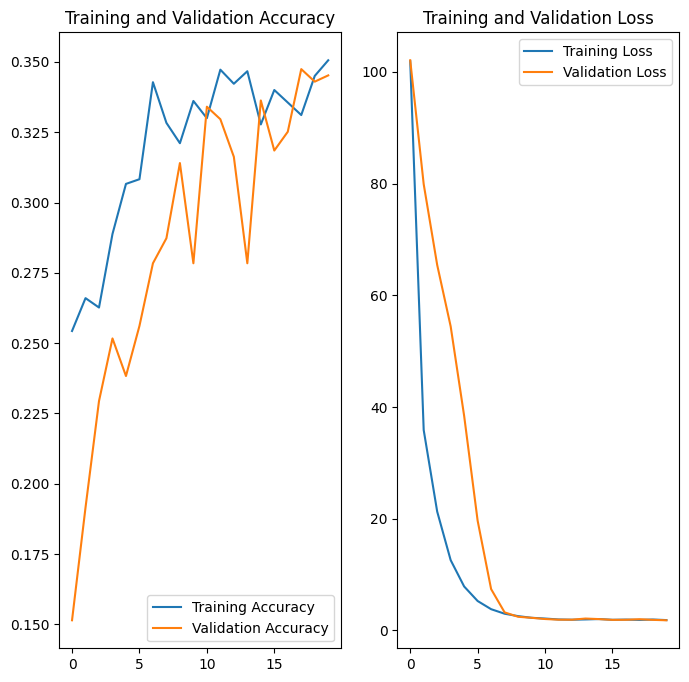

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Writing findings after the model fit, to see if there is an evidence of model overfit or underfit. Checking is there any some improvement now as compared to the previous model run?

Above Model became **underfit** as both training and validation accuracy is low compared to the previous model.
However, there is no major gap between train and test accuracy. This is improved compared to earlier model

#### Finding the distribution of classes in the training dataset.

In [22]:
# Counting images in each class
class_counts = {cls.name: len(list(cls.glob("*.jpg"))) for cls in data_dir_train.iterdir() if cls.is_dir()}

# Printing class counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

actinic keratosis: 114 images
dermatofibroma: 95 images
seborrheic keratosis: 77 images
basal cell carcinoma: 381 images
squamous cell carcinoma: 181 images
pigmented benign keratosis: 462 images
melanoma: 438 images
vascular lesion: 139 images
nevus: 359 images


#### Writing findings here:
#### - Which class has the least number of samples?
##### seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
##### pigmented benign keratosis


#### Rectifying the class imbalance

In [23]:
!pip install Augmentor

Using `Augmentor`, and the following general procedure is followed:

1. Instantiating a `Pipeline` object pointing to a directory containing the initial image data set.<br>
2. Defining the number of operations to perform on this data set using the `Pipeline` object.<br>
3. Executing these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
import Augmentor

path_to_training_dataset = "/content/drive/MyDrive/CNNDataSet/Train"

for i in class_names:
    # Creating the correct path to the subdirectory for the current class
    current_class_path = os.path.join(path_to_training_dataset, i)

    # Instantiating the Augmentor Pipeline with the correct path
    p = Augmentor.Pipeline(current_class_path)

    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNNDataSet/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA8BA328950>: 100%|██████████| 500/500 [00:21<00:00, 23.33 Samples/s]


Initialised with 381 image(s) found.
Output directory set to /content/drive/MyDrive/CNNDataSet/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA900341C90>: 100%|██████████| 500/500 [00:20<00:00, 24.73 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNNDataSet/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA9102A29D0>: 100%|██████████| 500/500 [00:21<00:00, 23.62 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNNDataSet/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FA900217910>: 100%|██████████| 500/500 [01:17<00:00,  6.46 Samples/s]


Initialised with 359 image(s) found.
Output directory set to /content/drive/MyDrive/CNNDataSet/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FA9182F0850>: 100%|██████████| 500/500 [01:06<00:00,  7.57 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNNDataSet/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA8E9941590>: 100%|██████████| 500/500 [00:18<00:00, 27.24 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNNDataSet/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA8E998F550>: 100%|██████████| 500/500 [00:37<00:00, 13.41 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNNDataSet/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA9001B4FD0>: 100%|██████████| 500/500 [00:18<00:00, 27.49 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNNDataSet/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA8BA38F390>: 100%|██████████| 500/500 [00:18<00:00, 27.14 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Taking a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Seeing the distribution of augmented data after adding new images to the original training data.

In [26]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','*.jpg'))]
path_list

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/CNNDataSet/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_5e0ad945-ccd0-4838-8f63-b0721e9c9a52.jpg',
 '/content/drive/MyDrive/CNNDataSet/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_198f21e3-a4fa-478f-a6a7-547c32b4e095.jpg',
 '/content/drive/MyDrive/CNNDataSet/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_d22f4f16-8c9e-4e48-bc7e-8c5e0528e061.jpg',
 '/content/drive/MyDrive/CNNDataSet/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_ebe76d54-4b26-453a-bdc0-ae7e2c86d81e.jpg',
 '/content/drive/MyDrive/CNNDataSet/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030826.jpg_201e8421-62e9-4a32-b170-44439b52fe9c.jpg',
 '/content/drive/MyDrive/CNNDataSet/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_af98d0c1-174a-45bb-a599-b40ed7ae9040.jpg',
 '/content/drive/MyDrive/CNNDataSet/Train/actinic keratosis/output/actinic k

In [27]:
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [28]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNNDataSet/Train/actini...,Train
1,/content/drive/MyDrive/CNNDataSet/Train/actini...,Train
2,/content/drive/MyDrive/CNNDataSet/Train/actini...,Train
3,/content/drive/MyDrive/CNNDataSet/Train/actini...,Train
4,/content/drive/MyDrive/CNNDataSet/Train/actini...,Train
...,...,...
2241,/content/drive/MyDrive/CNNDataSet/Train/nevus/...,Train
2242,/content/drive/MyDrive/CNNDataSet/Train/nevus/...,Train
2243,/content/drive/MyDrive/CNNDataSet/Train/nevus/...,Train
2244,/content/drive/MyDrive/CNNDataSet/Train/nevus/...,Train


In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

Following are the newly added images for all categories

In [31]:
new_df['Label'].value_counts()

,count
Label,
Train,2246
actinic keratosis,500
dermatofibroma,500
seborrheic keratosis,500
basal cell carcinoma,500
squamous cell carcinoma,500
pigmented benign keratosis,500
melanoma,500
vascular lesion,500


Added 500 images to all the classes to maintain some class balance.

#### Training the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [36]:
data_dir_train="/content/drive/MyDrive/CNNDataSet/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6746 files belonging to 9 classes.
Using 5397 files for training.


#### Creating a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6746 files belonging to 9 classes.
Using 1349 files for validation.


#### Creating the model

In [42]:
model = Sequential([
                    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width,3))
                   ])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same',
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### Compiling the model by choosing appropriate optimizer and loss function

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │         278,793 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 344,361 (1.31 MB)

 Trainable params: 344,361 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the model

In [44]:
epochs = 30
## Using 30 epochs.
history =model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 267ms/step - accuracy: 0.1782 - loss: 2.1244 - val_accuracy: 0.3929 - val_loss: 1.5537
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.4253 - loss: 1.5108 - val_accuracy: 0.4959 - val_loss: 1.3227
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - accuracy: 0.4982 - loss: 1.3442 - val_accuracy: 0.4640 - val_loss: 1.3910
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 232ms/step - accuracy: 0.5385 - loss: 1.2503 - val_accuracy: 0.5434 - val_loss: 1.3320
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - accuracy: 0.5856 - loss: 1.1223 - val_accuracy: 0.6056 - val_loss: 1.1416
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 233ms/step - accuracy: 0.6410 - loss: 1.0005 - val_accuracy: 0.6323 - val_loss: 1.1679
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 238ms/step - accuracy: 0.6642 - loss: 0.9188 - val_accuracy: 0.6679 - val_loss: 1.1096
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 240ms/step - accuracy: 0.7482 - loss: 0

#### Visualizing the model results

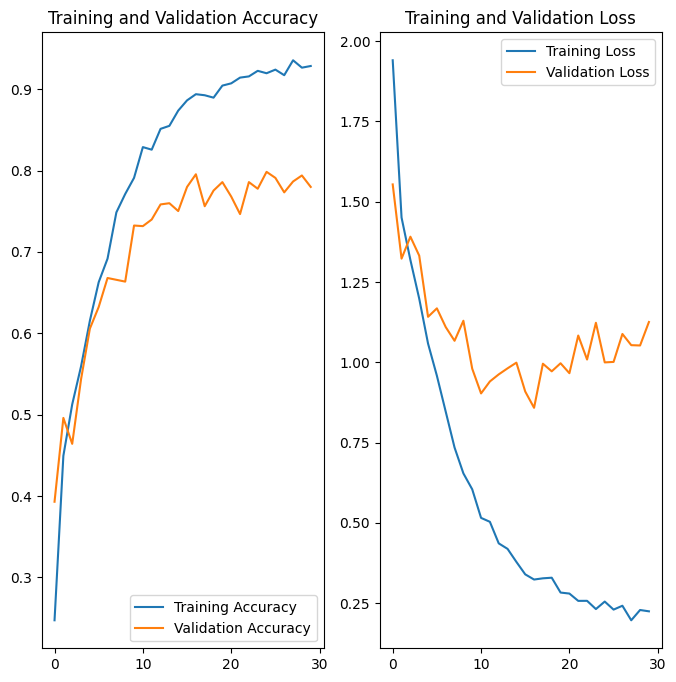

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



 Yes, able to get rid of underfitting/overfitting.<br/>
 Class rebalance helped a lot due to this training accuracy and test accuracy improved a lot. Also, there is no major diffence between train and test accuracy. <br/>
 Hence, model improved a lot compared to earlier models.